In [1]:
import pandas as pd
import numpy as np
import altair as alt

In [2]:
# Comment out the render png and restart the notebook for the interactice dashboard
alt.renderers.enable('png')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

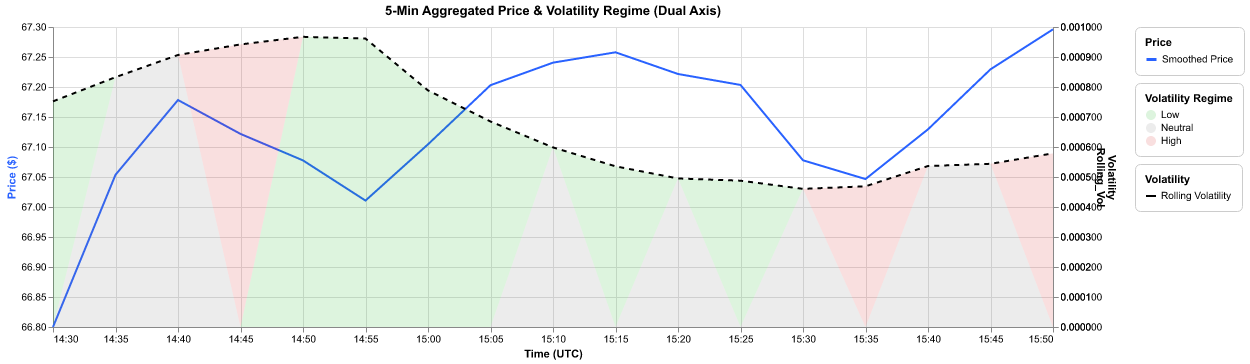

In [3]:
# Load data
raw_mags_df = pd.read_csv("master_raw_mags_1m.csv")
results_df = pd.read_csv("results (2).csv")

# Clean datetime columns
raw_mags_df['Datetime'] = pd.to_datetime(
    raw_mags_df['Datetime'], utc=True).dt.tz_localize(None)
results_df['Datetime'] = pd.to_datetime(results_df['Datetime'])
results_df = results_df[['Datetime', 'regime_label']].rename(
    columns={'regime_label': 'Regime'})

# Calculate features
raw_mags_df['Smoothed_Close'] = raw_mags_df['close'].rolling(
    window=5, min_periods=1).mean()
raw_mags_df['Log_Return'] = np.log(
    raw_mags_df['close'] / raw_mags_df['close'].shift(1))
raw_mags_df['Rolling_Vol'] = raw_mags_df['Log_Return'].rolling(
    window=30, min_periods=10).std()

# Merge price data with regime labels
plot_df = pd.merge(
    raw_mags_df[['Datetime', 'Smoothed_Close', 'Rolling_Vol']],
    results_df,
    on='Datetime',
    how='inner'
).dropna(subset=['Rolling_Vol', 'Regime'])

# Resample to 5-minute intervals
plot_df = plot_df.set_index('Datetime')
plot_df['Date'] = plot_df.index.strftime('%Y-%m-%d')

agg_df = plot_df.resample('5T').agg({
    'Smoothed_Close': 'mean',
    'Rolling_Vol': 'mean',
    'Regime': lambda x: x.mode()[0] if not x.empty else None,
    'Date': 'first'
}).dropna(subset=['Rolling_Vol']).reset_index()

# Chart settings
regime_order = ['Low', 'Neutral', 'High']
regime_colors = ['#1fb426', '#7f7f7f', '#d62728']

# Date dropdown filter
date_options = agg_df['Date'].unique().tolist()
latest_date = date_options[-1]

date_param = alt.param(
    name='DateSelector',
    value=latest_date,
    bind=alt.binding_select(options=date_options, name='Select Date: ')
)

# Base chart with filter
base = alt.Chart(agg_df).add_params(date_param).transform_filter(
    alt.FieldEqualPredicate(field='Date', equal=date_param)
).properties(
    title='5-Min Aggregated Price & Volatility Regime (Dual Axis)',
    width=1000
)

# Price line with legend
price_line = base.transform_calculate(
    Price_Label='"Smoothed Price"'
).mark_line(strokeWidth=2).encode(
    alt.X('Datetime:T', title='Time (UTC)', axis=alt.Axis(format='%H:%M')),
    alt.Y('Smoothed_Close:Q', title='Price ($)', scale=alt.Scale(zero=False),
          axis=alt.Axis(titleColor='#2962FF', format='.2f')),
    alt.Color('Price_Label:N',
              title='Price',
              scale=alt.Scale(domain=['Smoothed Price'], range=['#2962FF']),
              legend=alt.Legend(orient='right', symbolStrokeWidth=3)),
    tooltip=[
        alt.Tooltip('Datetime:T', title='Time', format='%Y-%m-%d %H:%M'),
        alt.Tooltip('Smoothed_Close:Q', title='Smoothed Price', format='$.4f'),
        alt.Tooltip('Rolling_Vol:Q', title='Volatility', format='.6f'),
        alt.Tooltip('Regime:N', title='Regime')
    ]
)

# Regime colored area (right y-axis)
vol_area = base.mark_area(opacity=0.15).encode(
    alt.X('Datetime:T'),
    alt.Y('Rolling_Vol:Q', title='Volatility', scale=alt.Scale(zero=False),
          axis=alt.Axis(titleColor='black', format='.6f')),
    alt.Color('Regime:N',
              title='Volatility Regime',
              scale=alt.Scale(domain=regime_order, range=regime_colors),
              legend=alt.Legend(orient='right'))
)

# Volatility line with legend
vol_line = base.transform_calculate(
    Vol_Label='"Rolling Volatility"'
).mark_line(strokeWidth=2, strokeDash=[5, 5]).encode(
    alt.X('Datetime:T'),
    alt.Y('Rolling_Vol:Q'),
    alt.Color('Vol_Label:N',
              title='Volatility',
              scale=alt.Scale(domain=['Rolling Volatility'], range=['black']),
              legend=alt.Legend(orient='right', symbolStrokeWidth=2)),
    tooltip=[
        alt.Tooltip('Datetime:T', title='Time', format='%Y-%m-%d %H:%M'),
        alt.Tooltip('Rolling_Vol:Q', title='Rolling Volatility', format='.6f'),
        alt.Tooltip('Smoothed_Close:Q', title='Price', format='$.4f'),
        alt.Tooltip('Regime:N', title='Regime')
    ]
)

# Combine with dual y-axis
chart = (price_line + vol_area + vol_line).resolve_scale(
    y='independent',
    color='independent'
).configure_legend(
    strokeColor='#CCC',
    fillColor='#FFF',
    padding=10,
    cornerRadius=5
)

chart

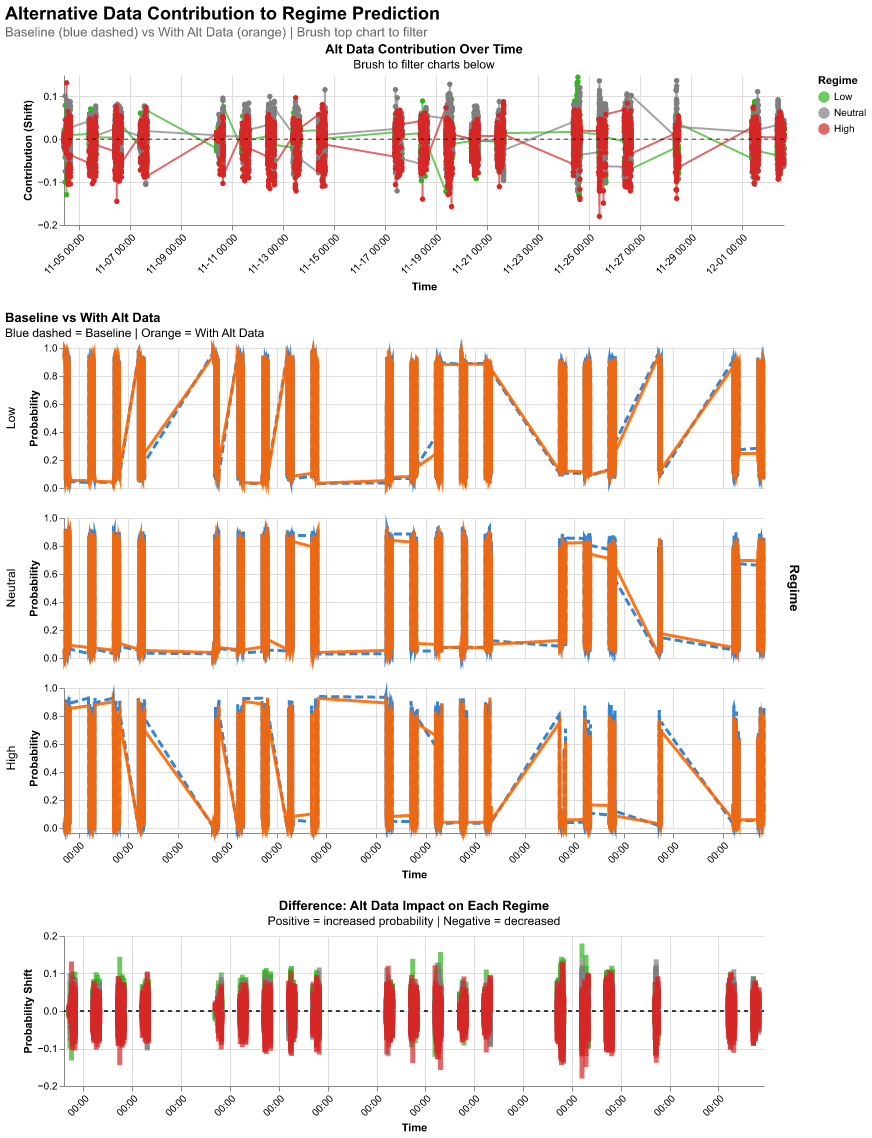

In [4]:
# Load data
df = pd.read_csv('results (2).csv')
news_df = pd.read_csv('news_sentiment.csv')

# Clean datetime
df.columns = [col.strip() for col in df.columns]
df = df.drop(df.columns[0], axis=1, errors='ignore')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Date'] = df['Datetime'].dt.strftime('%Y-%m-%d')

# Process sentiment
news_df = news_df[['datetime', 'sent_net']].rename(
    columns={'datetime': 'Datetime'})
news_df['Datetime'] = pd.to_datetime(
    news_df['Datetime'], utc=True).dt.tz_localize(None)
news_df = news_df.groupby('Datetime')['sent_net'].mean().reset_index()
news_df = news_df.set_index('Datetime').resample(
    '1T').ffill().dropna().reset_index()

# Calculate contributions
df['Contribution_Low'] = df['probability_low_with_alt'] - df['probability_low']
df['Contribution_Medium'] = df['probability_medium_with_alt'] - \
    df['probability_medium']
df['Contribution_High'] = df['probability_high_with_alt'] - df['probability_high']
df['Lag_10m'] = df['Contribution_High'].shift(10)

# Merge with sentiment
df_plot = df.dropna(subset=['Lag_10m'])
df_plot = pd.merge_asof(
    df_plot.sort_values('Datetime'),
    news_df.sort_values('Datetime'),
    on='Datetime',
    direction='backward',
    allow_exact_matches=True
).dropna(subset=['Lag_10m', 'sent_net']).copy()

# Reshape for faceting
id_vars = ['Datetime', 'Date', 'regime_label', 'Lag_10m', 'sent_net']

# With-alt probabilities
df_prob = df_plot.melt(
    id_vars=id_vars,
    value_vars=['probability_low_with_alt',
                'probability_medium_with_alt', 'probability_high_with_alt'],
    var_name='col', value_name='Probability_Value'
)
df_prob['Regime'] = df_prob['col'].str.replace('probability_', '').str.replace(
    '_with_alt', '').str.title().replace('Medium', 'Neutral')

# Contributions
df_contrib = df_plot.melt(
    id_vars=id_vars,
    value_vars=['Contribution_Low',
                'Contribution_Medium', 'Contribution_High'],
    var_name='col', value_name='Contribution_Value'
)
df_contrib['Regime'] = df_contrib['col'].str.replace(
    'Contribution_', '').str.title().replace('Medium', 'Neutral')

# Baseline probabilities
df_baseline = df_plot.melt(
    id_vars=id_vars,
    value_vars=['probability_low', 'probability_medium', 'probability_high'],
    var_name='col', value_name='Probability_Baseline'
)
df_baseline['Regime'] = df_baseline['col'].str.replace(
    'probability_', '').str.title().replace('Medium', 'Neutral')

# Merge all together
df_final = pd.merge(df_prob.drop(columns=['col']), df_contrib.drop(columns=['col']),
                    on=id_vars + ['Regime'], how='inner')
df_final = pd.merge(df_final, df_baseline[['Datetime', 'Regime', 'Probability_Baseline']],
                    on=['Datetime', 'Regime'], how='inner')

# Settings
regime_order = ['Low', 'Neutral', 'High']
regime_colors = ['#30b41f', '#7f7f7f', '#d62727']

# Filters
date_options = ['All Dates'] + sorted(df_final['Date'].unique().tolist())
date_param = alt.param(name='DateFilter', value='All Dates',
                       bind=alt.binding_select(options=date_options, name='Select Date: '))
brush = alt.selection_interval(encodings=['x'])

# Chart 1: Contribution over time
time_line = alt.Chart(df_final).transform_filter(
    "(DateFilter === 'All Dates') || (datum.Date === DateFilter)"
).mark_line(point=True, strokeWidth=2, opacity=0.7).encode(
    alt.X('Datetime:T', title='Time', axis=alt.Axis(
        format='%m-%d %H:%M', labelAngle=-45)),
    alt.Y('Contribution_Value:Q', title='Contribution (Shift)'),
    alt.Color('Regime:N', scale=alt.Scale(domain=regime_order, range=regime_colors),
              legend=alt.Legend(title='Regime', orient='right')),
    tooltip=[
        alt.Tooltip('Datetime:T', title='Time', format='%Y-%m-%d %H:%M'),
        alt.Tooltip('Regime:N'),
        alt.Tooltip('Contribution_Value:Q', title='Shift', format='.4f'),
        alt.Tooltip('Probability_Baseline:Q', title='Baseline', format='.4f'),
        alt.Tooltip('Probability_Value:Q', title='With Alt', format='.4f')
    ]
)

zero_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(
    color='black', strokeDash=[4, 4], strokeWidth=1.5, opacity=0.5).encode(alt.Y('y:Q'))

time_chart = alt.layer(time_line, zero_line).add_params(date_param, brush).properties(
    width=720, height=150,
    title={'text': 'Alt Data Contribution Over Time',
           'subtitle': 'Brush to filter charts below'}
)

# Chart 2: Baseline vs With Alt Data overlay
base = alt.Chart(df_final).transform_filter(
    "(DateFilter === 'All Dates') || (datum.Date === DateFilter)"
).transform_filter(brush)

baseline_line = base.mark_line(strokeWidth=3, strokeDash=[8, 4], color='#0066CC', opacity=0.8).encode(
    alt.X('Datetime:T', title='Time', axis=alt.Axis(
        format='%H:%M', labelAngle=-45)),
    alt.Y('Probability_Baseline:Q', title='Probability',
          scale=alt.Scale(zero=False)),
    tooltip=[alt.Tooltip('Datetime:T', format='%Y-%m-%d %H:%M'), alt.Tooltip('Regime:N'),
             alt.Tooltip('Probability_Baseline:Q', title='Baseline', format='.4f')]
)

alt_line = base.mark_line(strokeWidth=3, color='#FF6600', opacity=0.9).encode(
    alt.X('Datetime:T'),
    alt.Y('Probability_Value:Q'),
    tooltip=[alt.Tooltip('Datetime:T', format='%Y-%m-%d %H:%M'), alt.Tooltip('Regime:N'),
             alt.Tooltip('Probability_Value:Q',
                         title='With Alt', format='.4f'),
             alt.Tooltip('Contribution_Value:Q', title='Shift', format='.4f')]
)

comparison_chart = alt.layer(baseline_line, alt_line).properties(width=700, height=140).facet(
    row=alt.Row('Regime:N', sort=regime_order, title='Regime',
                header=alt.Header(titleOrient='right', labelOrient='left', titleFontSize=13, labelFontSize=12))
).resolve_scale(y='independent').properties(
    title={'text': 'Baseline vs With Alt Data',
           'subtitle': 'Blue dashed = Baseline | Orange = With Alt Data'}
)

# Chart 3: Difference bars
diff_bars = base.mark_bar(opacity=0.7).encode(
    alt.X('Datetime:T', title='Time', axis=alt.Axis(
        format='%H:%M', labelAngle=-45)),
    alt.Y('Contribution_Value:Q', title='Probability Shift'),
    alt.Color('Regime:N', scale=alt.Scale(
        domain=regime_order, range=regime_colors), legend=None),
    tooltip=[alt.Tooltip('Datetime:T', format='%Y-%m-%d %H:%M'), alt.Tooltip('Regime:N'),
             alt.Tooltip('Contribution_Value:Q', title='Shift', format='.4f')]
)

diff_zero = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(
    color='black', strokeWidth=1.5, strokeDash=[4, 4]).encode(alt.Y('y:Q'))

diff_chart = alt.layer(diff_zero, diff_bars).properties(
    width=700, height=150,
    title={'text': 'Difference: Alt Data Impact on Each Regime',
           'subtitle': 'Positive = increased probability | Negative = decreased'}
)

# Combine all charts
chart = alt.vconcat(
    time_chart,
    comparison_chart,
    diff_chart
).properties(
    title={
        'text': 'Alternative Data Contribution to Regime Prediction',
        'subtitle': 'Baseline (blue dashed) vs With Alt Data (orange) | Brush top chart to filter',
        'fontSize': 18, 'fontWeight': 'bold', 'subtitleFontSize': 13, 'subtitleColor': '#666666'
    }
).configure_view(strokeWidth=0)

chart

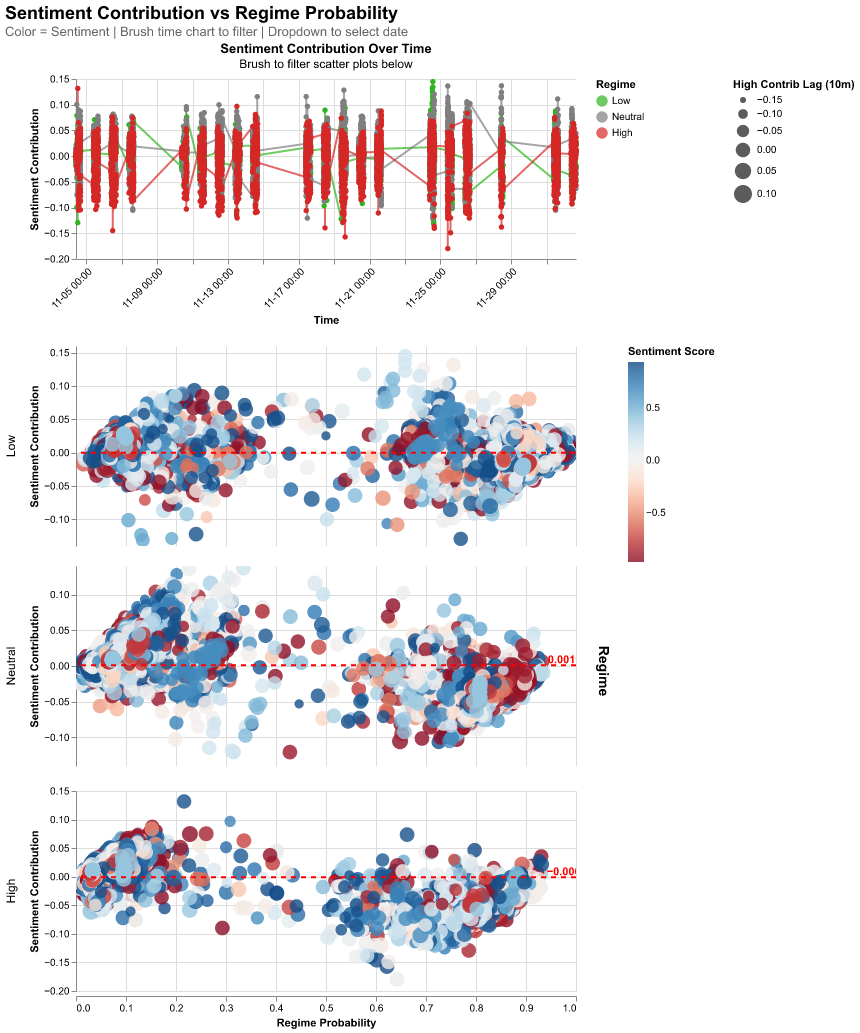

In [5]:
# Load data
df = pd.read_csv('results (2).csv')
news_df = pd.read_csv('news_sentiment.csv')

# Clean datetime
df.columns = [col.strip() for col in df.columns]
df = df.drop(df.columns[0], axis=1, errors='ignore')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Date'] = df['Datetime'].dt.strftime('%Y-%m-%d')

# Process sentiment
news_df = news_df[['datetime', 'sent_net']].rename(
    columns={'datetime': 'Datetime'})
news_df['Datetime'] = pd.to_datetime(
    news_df['Datetime'], utc=True).dt.tz_localize(None)
news_df = news_df.groupby('Datetime')['sent_net'].mean().reset_index()
news_df = news_df.set_index('Datetime').resample(
    '1T').ffill().dropna().reset_index()

# Calculate contributions
df['Contribution_Low'] = df['probability_low_with_alt'] - df['probability_low']
df['Contribution_Medium'] = df['probability_medium_with_alt'] - \
    df['probability_medium']
df['Contribution_High'] = df['probability_high_with_alt'] - df['probability_high']
df['Lag_10m'] = df['Contribution_High'].shift(10)

# Merge with sentiment
df_plot = df.dropna(subset=['Lag_10m'])
df_plot = pd.merge_asof(
    df_plot.sort_values('Datetime'),
    news_df.sort_values('Datetime'),
    on='Datetime',
    direction='backward',
    allow_exact_matches=True
).dropna(subset=['Lag_10m', 'sent_net']).copy()

# Reshape for faceting
id_vars = ['Datetime', 'Date', 'regime_label', 'Lag_10m', 'sent_net']

df_prob = df_plot.melt(
    id_vars=id_vars,
    value_vars=['probability_low_with_alt',
                'probability_medium_with_alt', 'probability_high_with_alt'],
    var_name='col', value_name='Probability_Value'
)
df_prob['Regime'] = df_prob['col'].str.extract(
    r'probability_(\w+)_with')[0].str.title().replace('Medium', 'Neutral')

df_contrib = df_plot.melt(
    id_vars=id_vars,
    value_vars=['Contribution_Low',
                'Contribution_Medium', 'Contribution_High'],
    var_name='col', value_name='Contribution_Value'
)
df_contrib['Regime'] = df_contrib['col'].str.replace(
    'Contribution_', '').str.title().replace('Medium', 'Neutral')

df_final = pd.merge(
    df_prob.drop(columns=['col']),
    df_contrib.drop(columns=['col']),
    on=id_vars + ['Regime'],
    how='inner'
)

# Settings
regime_order = ['Low', 'Neutral', 'High']
regime_colors = ['#30b41f', '#7f7f7f', '#d62727']

# Filters
date_options = ['All Dates'] + sorted(df_final['Date'].unique().tolist())
date_param = alt.param(name='DateFilter', value='All Dates',
                       bind=alt.binding_select(options=date_options, name='Select Date: '))
brush = alt.selection_interval(encodings=['x'])

# Time series chart (top)
time_chart = alt.Chart(df_final).add_params(date_param, brush).transform_filter(
    "(DateFilter === 'All Dates') || (datum.Date === DateFilter)"
).mark_line(point=True, strokeWidth=2, opacity=0.7).encode(
    alt.X('Datetime:T', title='Time', axis=alt.Axis(
        format='%m-%d %H:%M', labelAngle=-45)),
    alt.Y('Contribution_Value:Q', title='Sentiment Contribution'),
    alt.Color('Regime:N', scale=alt.Scale(domain=regime_order, range=regime_colors),
              legend=alt.Legend(title='Regime', orient='right')),
    tooltip=[
        alt.Tooltip('Datetime:T', title='Time', format='%Y-%m-%d %H:%M'),
        alt.Tooltip('Regime:N'),
        alt.Tooltip('Contribution_Value:Q',
                    title='Contribution', format='.4f'),
        alt.Tooltip('sent_net:Q', title='Sentiment', format='.4f')
    ]
).properties(
    width=500, height=180,
    title={'text': 'Sentiment Contribution Over Time',
           'subtitle': 'Brush to filter scatter plots below'}
)

# Scatter plot base (filtered by brush)
base = alt.Chart(df_final).add_params(date_param).transform_filter(
    "(DateFilter === 'All Dates') || (datum.Date === DateFilter)"
).transform_filter(brush).properties(width=500, height=200)

scatter = base.mark_point(filled=True, opacity=0.8, size=80).encode(
    alt.X('Probability_Value:Q', title='Regime Probability',
          scale=alt.Scale(domain=[0, 1])),
    alt.Y('Contribution_Value:Q', title='Sentiment Contribution'),
    alt.Color('sent_net:Q', title='Sentiment Score',
              scale=alt.Scale(scheme='redblue', domainMid=0), legend=alt.Legend(orient='right')),
    alt.Size('Lag_10m:Q', title='High Contrib Lag (10m)',
             legend=alt.Legend(orient='right')),
    tooltip=[
        alt.Tooltip('Datetime:T', title='Time', format='%Y-%m-%d %H:%M'),
        alt.Tooltip('regime_label:N', title='Predicted Regime'),
        alt.Tooltip('Probability_Value:Q', title='Probability', format='.4f'),
        alt.Tooltip('Contribution_Value:Q',
                    title='Contribution', format='.4f'),
        alt.Tooltip('sent_net:Q', title='Sentiment', format='.4f')
    ]
).interactive()

mean_line = base.mark_rule(color='red', strokeDash=[5, 5], strokeWidth=2).encode(
    alt.Y('mean(Contribution_Value):Q')
)

mean_text = base.mark_text(align='left', dx=5, dy=-5, fontSize=11, fontWeight='bold', color='red').encode(
    alt.X('max(Probability_Value):Q'),
    alt.Y('mean(Contribution_Value):Q'),
    text=alt.Text('mean(Contribution_Value):Q', format='.4f')
)

# Faceted scatter
faceted_scatter = (scatter + mean_line + mean_text).facet(
    row=alt.Row('Regime:N', sort=regime_order, title='Regime',
                header=alt.Header(titleOrient='right', labelOrient='left', titleFontSize=14, labelFontSize=12))
).resolve_scale(y='independent')

# Combine charts
chart = alt.vconcat(time_chart, faceted_scatter).properties(
    title={
        'text': 'Sentiment Contribution vs Regime Probability',
        'subtitle': 'Color = Sentiment | Brush time chart to filter | Dropdown to select date',
        'fontSize': 18, 'fontWeight': 'bold', 'subtitleFontSize': 13, 'subtitleColor': '#666666'
    }
).configure_view(strokeWidth=0)

chart

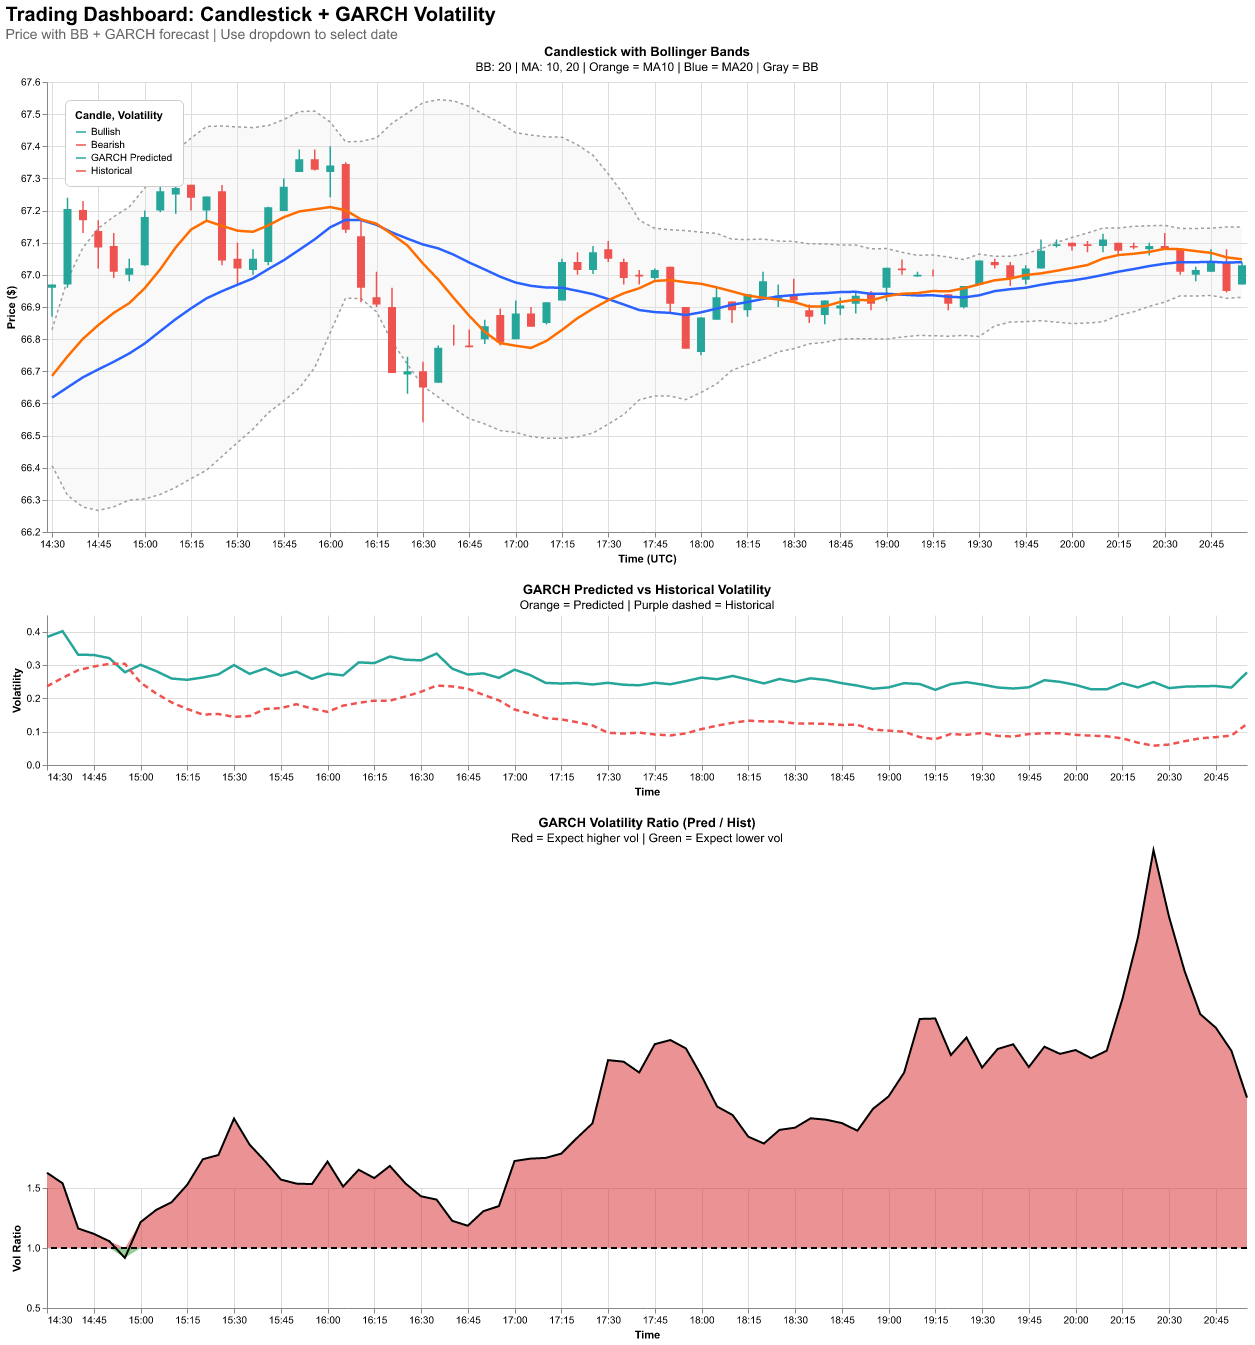

In [6]:
# Load data
df_garch = pd.read_csv('features_garch.csv')

# Clean datetime
raw_mags_df['Datetime'] = pd.to_datetime(
    raw_mags_df['Datetime'], utc=True).dt.tz_localize(None)
df_garch['Datetime'] = pd.to_datetime(
    df_garch['Datetime'], utc=True).dt.tz_localize(None)

# Resample price to 5-min
df_5min = raw_mags_df.set_index('Datetime').resample('5T').agg({
    'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'
}).dropna().reset_index()

# Resample GARCH to 5-min
df_garch_5min = df_garch.set_index('Datetime').resample('5T').agg({
    'pred_vol': 'mean', 'hist_vol': 'mean', 'vol_ratio': 'mean'
}).dropna().reset_index()

# Merge GARCH with price
df_5min = pd.merge_asof(df_5min.sort_values('Datetime'), df_garch_5min.sort_values('Datetime'),
                        on='Datetime', direction='nearest')
df_5min['Date'] = df_5min['Datetime'].dt.strftime('%Y-%m-%d')

# Calculate indicators
df_5min['MA_20'] = df_5min['close'].rolling(window=20).mean()
df_5min['StdDev'] = df_5min['close'].rolling(window=20).std()
df_5min['Upper_BB'] = df_5min['MA_20'] + 2 * df_5min['StdDev']
df_5min['Lower_BB'] = df_5min['MA_20'] - 2 * df_5min['StdDev']
df_5min['MA_10'] = df_5min['close'].rolling(window=10).mean()

chart_df = df_5min.dropna(subset=['MA_20', 'MA_10']).copy()
chart_df['Candle_Type'] = np.where(
    chart_df['close'] > chart_df['open'], 'Bullish', 'Bearish')

# Date filter
date_options = chart_df['Date'].unique().tolist()
date_param = alt.param(name='DateSelector', value=date_options[-1],
                       bind=alt.binding_select(options=date_options, name='Select Date: '))

# Base chart
base = alt.Chart(chart_df).add_params(date_param).transform_filter(
    alt.FieldEqualPredicate(field='Date', equal=date_param)
)

x_enc = alt.X('Datetime:T', title='Time (UTC)', axis=alt.Axis(
    format='%H:%M', labelAngle=0, tickCount=20))

tooltip = [
    alt.Tooltip('Datetime:T', title='Time', format='%Y-%m-%d %H:%M'),
    alt.Tooltip('open:Q', title='Open', format='$.4f'),
    alt.Tooltip('high:Q', title='High', format='$.4f'),
    alt.Tooltip('low:Q', title='Low', format='$.4f'),
    alt.Tooltip('close:Q', title='Close', format='$.4f'),
    alt.Tooltip('vol_ratio:Q', title='Vol Ratio', format='.4f')
]

# Candlestick layers
bb_area = base.mark_area(color='#E8E8E8', opacity=0.3).encode(
    x_enc, alt.Y('Upper_BB:Q', title='Price ($)', scale=alt.Scale(zero=False)), alt.Y2('Lower_BB:Q'), tooltip=tooltip)

bb_upper = base.mark_line(color='#9E9E9E', strokeWidth=1.5, strokeDash=[3, 3]).encode(
    x_enc, alt.Y('Upper_BB:Q', scale=alt.Scale(zero=False)), tooltip=tooltip)

bb_lower = base.mark_line(color='#9E9E9E', strokeWidth=1.5, strokeDash=[3, 3]).encode(
    x_enc, alt.Y('Lower_BB:Q', scale=alt.Scale(zero=False)), tooltip=tooltip)

wicks = base.mark_rule(size=1.5).encode(
    x_enc, alt.Y('low:Q', scale=alt.Scale(zero=False)), alt.Y2('high:Q'),
    alt.Color('Candle_Type:N', scale=alt.Scale(domain=['Bullish', 'Bearish'], range=['#26A69A', '#EF5350']),
              legend=alt.Legend(title='Candle', orient='top-left')), tooltip=tooltip)

candles = base.mark_bar(size=8).encode(
    x_enc, alt.Y('open:Q', scale=alt.Scale(zero=False)), alt.Y2('close:Q'),
    alt.Color('Candle_Type:N', scale=alt.Scale(domain=['Bullish', 'Bearish'], range=['#26A69A', '#EF5350']),
              legend=None), tooltip=tooltip)

ma_20 = base.mark_line(strokeWidth=2.5, color='#2962FF').encode(
    x_enc, alt.Y('MA_20:Q', scale=alt.Scale(zero=False)), tooltip=tooltip)

ma_10 = base.mark_line(strokeWidth=2.5, color='#FF6D00').encode(
    x_enc, alt.Y('MA_10:Q', scale=alt.Scale(zero=False)), tooltip=tooltip)

candlestick_chart = (bb_area + bb_upper + bb_lower + wicks + candles + ma_20 + ma_10).properties(
    width=1200, height=450,
    title={'text': 'Candlestick with Bollinger Bands',
           'subtitle': 'BB: 20 | MA: 10, 20 | Orange = MA10 | Blue = MA20 | Gray = BB'}
).interactive(bind_y=False)

# GARCH Chart 1: Pred vs Hist Volatility
garch_df = chart_df.dropna(subset=['pred_vol', 'hist_vol', 'vol_ratio']).copy()

df_vol = garch_df.melt(
    id_vars=['Datetime', 'Date', 'vol_ratio'],
    value_vars=['pred_vol', 'hist_vol'],
    var_name='Type', value_name='Volatility'
)
df_vol['Type'] = df_vol['Type'].replace(
    {'pred_vol': 'GARCH Predicted', 'hist_vol': 'Historical'})

vol_chart = alt.Chart(df_vol).add_params(date_param).transform_filter(
    alt.FieldEqualPredicate(field='Date', equal=date_param)
).mark_line(strokeWidth=2.5).encode(
    alt.X('Datetime:T', title='Time', axis=alt.Axis(
        format='%H:%M', labelAngle=0, tickCount=20)),
    alt.Y('Volatility:Q', title='Volatility'),
    alt.Color('Type:N', scale=alt.Scale(domain=['GARCH Predicted', 'Historical'], range=['#FF6600', '#9933FF']),
              legend=alt.Legend(title='Volatility', orient='top-left')),
    alt.StrokeDash('Type:N', scale=alt.Scale(
        domain=['GARCH Predicted', 'Historical'], range=[[0], [6, 4]]), legend=None),
    tooltip=[alt.Tooltip('Datetime:T', format='%Y-%m-%d %H:%M'), alt.Tooltip('Type:N'),
             alt.Tooltip('Volatility:Q', format='.4f'), alt.Tooltip('vol_ratio:Q', format='.4f')]
).properties(
    width=1200, height=150,
    title={'text': 'GARCH Predicted vs Historical Volatility',
           'subtitle': 'Orange = Predicted | Purple dashed = Historical'}
)

# GARCH Chart 2: Volatility Ratio
garch_df['vol_above'] = garch_df['vol_ratio'].where(
    garch_df['vol_ratio'] >= 1, 1)
garch_df['vol_below'] = garch_df['vol_ratio'].where(
    garch_df['vol_ratio'] <= 1, 1)
garch_df['baseline'] = 1.0

ratio_base = alt.Chart(garch_df).add_params(date_param).transform_filter(
    alt.FieldEqualPredicate(field='Date', equal=date_param)
)

area_high = ratio_base.mark_area(opacity=0.5, color='#d62728').encode(
    alt.X('Datetime:T', title='Time', axis=alt.Axis(
        format='%H:%M', labelAngle=0, tickCount=20)),
    alt.Y('vol_above:Q', title='Vol Ratio', scale=alt.Scale(domain=[0.5, 1.5])), alt.Y2('baseline:Q'))

area_low = ratio_base.mark_area(opacity=0.5, color='#2ca02c').encode(
    alt.X('Datetime:T'), alt.Y('vol_below:Q', scale=alt.Scale(domain=[0.5, 1.5])), alt.Y2('baseline:Q'))

ratio_line = ratio_base.mark_line(color='black', strokeWidth=2).encode(
    alt.X('Datetime:T'), alt.Y('vol_ratio:Q'),
    tooltip=[alt.Tooltip('Datetime:T', format='%Y-%m-%d %H:%M'), alt.Tooltip('vol_ratio:Q', format='.4f'),
             alt.Tooltip('pred_vol:Q', format='.4f'), alt.Tooltip('hist_vol:Q', format='.4f')])

ref_line = alt.Chart(pd.DataFrame({'y': [1.0]})).mark_rule(
    color='black', strokeWidth=2, strokeDash=[6, 4]).encode(alt.Y('y:Q'))

ratio_chart = alt.layer(area_high, area_low, ratio_line, ref_line).properties(
    width=1200, height=120,
    title={'text': 'GARCH Volatility Ratio (Pred / Hist)',
           'subtitle': 'Red = Expect higher vol | Green = Expect lower vol'}
)

# Combine all charts
chart = alt.vconcat(candlestick_chart, vol_chart, ratio_chart).properties(
    title={'text': 'Trading Dashboard: Candlestick + GARCH Volatility',
           'subtitle': 'Price with BB + GARCH forecast | Use dropdown to select date',
           'fontSize': 20, 'fontWeight': 'bold', 'subtitleFontSize': 14, 'subtitleColor': '#666666'}
).configure_view(strokeWidth=0).configure_legend(strokeColor='#CCC', fillColor='#FFF', padding=10, cornerRadius=5)

chart

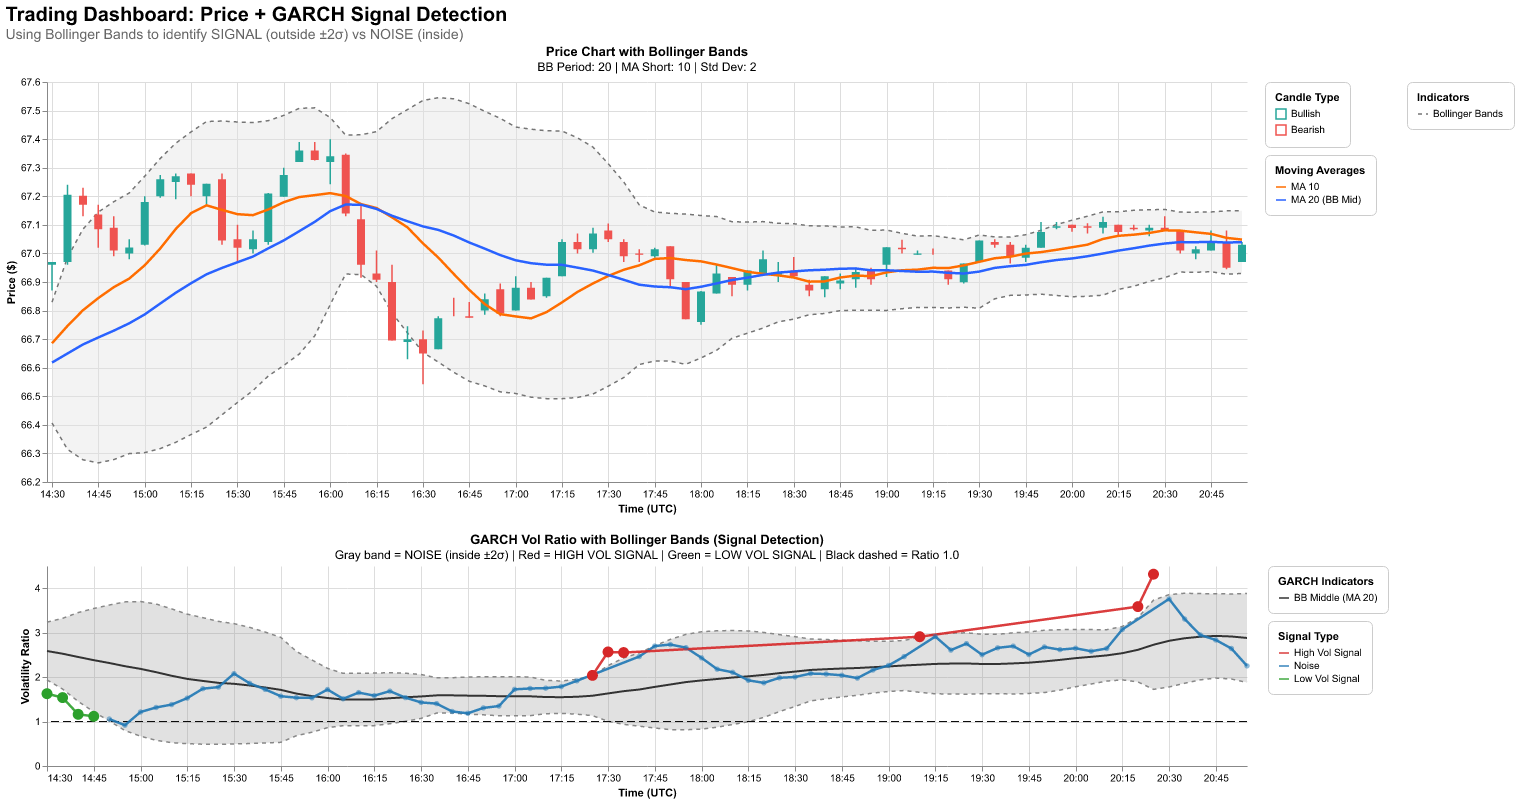

In [7]:
# Load data
df_garch = pd.read_csv('features_garch.csv')

# Clean datetime
raw_mags_df['Datetime'] = pd.to_datetime(
    raw_mags_df['Datetime'], utc=True).dt.tz_localize(None)
df_garch['Datetime'] = pd.to_datetime(
    df_garch['Datetime'], utc=True).dt.tz_localize(None)

# Resample price to 5-min
df_5min = raw_mags_df.set_index('Datetime').resample('5T').agg({
    'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'
}).dropna().reset_index()

# Resample GARCH to 5-min
df_garch_5min = df_garch.set_index('Datetime').resample('5T').agg({
    'pred_vol': 'mean', 'hist_vol': 'mean', 'vol_ratio': 'mean'
}).dropna().reset_index()

# Merge
df_5min = pd.merge_asof(df_5min.sort_values('Datetime'), df_garch_5min.sort_values('Datetime'),
                        on='Datetime', direction='nearest')
df_5min['Date'] = df_5min['Datetime'].dt.strftime('%Y-%m-%d')

# Price Bollinger Bands
df_5min['MA_20'] = df_5min['close'].rolling(20).mean()
df_5min['MA_10'] = df_5min['close'].rolling(10).mean()
df_5min['StdDev'] = df_5min['close'].rolling(20).std()
df_5min['Upper_BB'] = df_5min['MA_20'] + 2 * df_5min['StdDev']
df_5min['Lower_BB'] = df_5min['MA_20'] - 2 * df_5min['StdDev']

# GARCH Bollinger Bands for signal detection
df_5min['VR_MA'] = df_5min['vol_ratio'].rolling(20).mean()
df_5min['VR_Std'] = df_5min['vol_ratio'].rolling(20).std()
df_5min['VR_Upper'] = df_5min['VR_MA'] + 2 * df_5min['VR_Std']
df_5min['VR_Lower'] = df_5min['VR_MA'] - 2 * df_5min['VR_Std']

# Signal detection
df_5min['Signal'] = 'Noise'
df_5min.loc[df_5min['vol_ratio'] >
            df_5min['VR_Upper'], 'Signal'] = 'High Vol Signal'
df_5min.loc[df_5min['vol_ratio'] <
            df_5min['VR_Lower'], 'Signal'] = 'Low Vol Signal'
df_5min['Is_Signal'] = df_5min['Signal'] != 'Noise'

chart_df = df_5min.dropna(subset=['MA_20', 'VR_MA']).copy()
chart_df['Candle_Type'] = np.where(
    chart_df['close'] > chart_df['open'], 'Bullish', 'Bearish')

# Date filter
date_options = chart_df['Date'].unique().tolist()
date_param = alt.param(name='DateSelector', value=date_options[-1],
                       bind=alt.binding_select(options=date_options, name='Select Date: '))

# Base chart
base = alt.Chart(chart_df).add_params(date_param).transform_filter(
    alt.FieldEqualPredicate(field='Date', equal=date_param)
)

x_enc = alt.X('Datetime:T', title='Time (UTC)', axis=alt.Axis(
    format='%H:%M', labelAngle=0, tickCount=20))

tooltip = [
    alt.Tooltip('Datetime:T', title='Time', format='%Y-%m-%d %H:%M'),
    alt.Tooltip('open:Q', title='Open', format='$.4f'),
    alt.Tooltip('close:Q', title='Close', format='$.4f'),
    alt.Tooltip('vol_ratio:Q', title='Vol Ratio', format='.3f'),
    alt.Tooltip('Signal:N', title='Signal')
]

# Reshape MA data for legend
df_ma = chart_df.melt(id_vars=['Datetime', 'Date'], value_vars=['MA_10', 'MA_20'],
                      var_name='MA_Type', value_name='MA_Value')
df_ma['MA_Type'] = df_ma['MA_Type'].replace(
    {'MA_10': 'MA 10', 'MA_20': 'MA 20 (BB Mid)'})

# Candlestick chart
bb_area = base.mark_area(color='#E0E0E0', opacity=0.4).encode(
    x_enc, alt.Y('Upper_BB:Q', title='Price ($)', scale=alt.Scale(zero=False)), alt.Y2('Lower_BB:Q'))

bb_upper = base.transform_calculate(BB_Label='"Bollinger Bands"').mark_line(color='#757575', strokeWidth=1.5, strokeDash=[4, 4]).encode(
    x_enc, alt.Y('Upper_BB:Q', scale=alt.Scale(zero=False)),
    alt.StrokeDash('BB_Label:N', scale=alt.Scale(domain=['Bollinger Bands'], range=[[4, 4]]),
                   legend=alt.Legend(title='Indicators', orient='right')))

bb_lower = base.mark_line(color='#757575', strokeWidth=1.5, strokeDash=[4, 4]).encode(
    x_enc, alt.Y('Lower_BB:Q', scale=alt.Scale(zero=False)))

wicks = base.mark_rule(size=1.5).encode(
    x_enc, alt.Y('low:Q', scale=alt.Scale(zero=False)), alt.Y2('high:Q'),
    alt.Color('Candle_Type:N', title='Candle Type',
              scale=alt.Scale(domain=['Bullish', 'Bearish'], range=[
                              '#26A69A', '#EF5350']),
              legend=alt.Legend(orient='right', symbolType='square')), tooltip=tooltip)

candles = base.mark_bar(size=8).encode(
    x_enc, alt.Y('open:Q', scale=alt.Scale(zero=False)), alt.Y2('close:Q'),
    alt.Color('Candle_Type:N', scale=alt.Scale(domain=['Bullish', 'Bearish'], range=['#26A69A', '#EF5350']),
              legend=None), tooltip=tooltip)

ma_base = alt.Chart(df_ma).add_params(date_param).transform_filter(
    alt.FieldEqualPredicate(field='Date', equal=date_param))

ma_lines = ma_base.mark_line(strokeWidth=2.5).encode(
    alt.X('Datetime:T'), alt.Y('MA_Value:Q', scale=alt.Scale(zero=False)),
    alt.Color('MA_Type:N', title='Moving Averages',
              scale=alt.Scale(domain=['MA 10', 'MA 20 (BB Mid)'], range=[
                              '#FF6D00', '#2962FF']),
              legend=alt.Legend(orient='right')))

candlestick_chart = (bb_area + bb_upper + bb_lower + wicks + candles + ma_lines).properties(
    width=1200, height=400,
    title={'text': 'Price Chart with Bollinger Bands',
           'subtitle': 'BB Period: 20 | MA Short: 10 | Std Dev: 2'}
).resolve_scale(color='independent').interactive(bind_y=False)

# GARCH signal detection chart
garch_base = alt.Chart(chart_df).add_params(date_param).transform_filter(
    alt.FieldEqualPredicate(field='Date', equal=date_param)
)

bb_noise = garch_base.mark_area(opacity=0.25, color='#888888').encode(
    x_enc, alt.Y('VR_Upper:Q', title='Volatility Ratio', scale=alt.Scale(zero=False)), alt.Y2('VR_Lower:Q'))

bb_upper_vr = garch_base.mark_line(color='#888888', strokeWidth=1.5, strokeDash=[4, 4]).encode(
    alt.X('Datetime:T'), alt.Y('VR_Upper:Q'))

bb_lower_vr = garch_base.mark_line(color='#888888', strokeWidth=1.5, strokeDash=[4, 4]).encode(
    alt.X('Datetime:T'), alt.Y('VR_Lower:Q'))

ma_line = garch_base.transform_calculate(MA_Label='"BB Middle (MA 20)"').mark_line(strokeWidth=2).encode(
    alt.X('Datetime:T'), alt.Y('VR_MA:Q'),
    alt.Color('MA_Label:N', title='GARCH Indicators',
              scale=alt.Scale(domain=['BB Middle (MA 20)'], range=['#333333']),
              legend=alt.Legend(orient='right')))

signal_line = garch_base.mark_line(strokeWidth=2.5, opacity=0.9).encode(
    alt.X('Datetime:T'), alt.Y('vol_ratio:Q'),
    alt.Color('Signal:N', title='Signal Type',
              scale=alt.Scale(domain=['High Vol Signal', 'Noise', 'Low Vol Signal'], range=[
                              '#d62728', '#1f77b4', '#2ca02c']),
              legend=alt.Legend(orient='right')))

signal_points = garch_base.mark_circle().encode(
    alt.X('Datetime:T'), alt.Y('vol_ratio:Q'),
    alt.Color('Signal:N', scale=alt.Scale(domain=['High Vol Signal', 'Noise', 'Low Vol Signal'],
              range=['#d62728', '#1f77b4', '#2ca02c']), legend=None),
    alt.Size('Is_Signal:N', scale=alt.Scale(
        domain=[True, False], range=[120, 30]), legend=None),
    alt.Opacity('Is_Signal:N', scale=alt.Scale(
        domain=[True, False], range=[1.0, 0.5]), legend=None),
    tooltip=[
        alt.Tooltip('Datetime:T', title='Time', format='%Y-%m-%d %H:%M'),
        alt.Tooltip('vol_ratio:Q', title='Vol Ratio', format='.4f'),
        alt.Tooltip('Signal:N', title='Signal Type'),
        alt.Tooltip('pred_vol:Q', title='GARCH Pred Vol', format='.4f'),
        alt.Tooltip('hist_vol:Q', title='Historical Vol', format='.4f')
    ])

ref_line = alt.Chart(pd.DataFrame({'y': [1.0]})).mark_rule(
    color='black', strokeWidth=1, strokeDash=[8, 4]).encode(alt.Y('y:Q'))

garch_chart = alt.layer(bb_noise, bb_upper_vr, bb_lower_vr, ma_line, ref_line, signal_line, signal_points).properties(
    width=1200, height=200,
    title={'text': 'GARCH Vol Ratio with Bollinger Bands (Signal Detection)',
           'subtitle': 'Gray band = NOISE (inside ±2σ) | Red = HIGH VOL SIGNAL | Green = LOW VOL SIGNAL | Black dashed = Ratio 1.0'}
).resolve_scale(color='independent')

# Combine
chart = alt.vconcat(candlestick_chart, garch_chart).properties(
    title={'text': 'Trading Dashboard: Price + GARCH Signal Detection',
           'subtitle': 'Using Bollinger Bands to identify SIGNAL (outside ±2σ) vs NOISE (inside)',
           'fontSize': 20, 'fontWeight': 'bold', 'subtitleFontSize': 14, 'subtitleColor': '#666666'}
).configure_view(strokeWidth=0).configure_legend(strokeColor='#CCC', fillColor='#FFF', padding=10, cornerRadius=5)

chart